In [1]:
# !pip install ta
# !pip install pandas pandas_ta

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta
import pandas_ta as ta

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima
from pylab import rcParams
import requests
import json
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

In [3]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(
    period="max", 
    interval="1h",
)
print(msft_df.head())

                                 Open        High         Low       Close  \
Datetime                                                                    
2023-06-22 09:30:00-04:00  334.119995  338.559998  333.339996  337.410004   
2023-06-22 10:30:00-04:00  337.396210  337.980011  335.450012  336.690002   
2023-06-22 11:30:00-04:00  336.619995  338.755005  336.417511  337.239990   
2023-06-22 12:30:00-04:00  337.279999  337.649994  336.179993  337.260010   
2023-06-22 13:30:00-04:00  337.269989  338.470001  337.100006  338.179993   

                            Volume  Dividends  Stock Splits  
Datetime                                                     
2023-06-22 09:30:00-04:00  5860574        0.0           0.0  
2023-06-22 10:30:00-04:00  2979771        0.0           0.0  
2023-06-22 11:30:00-04:00  2222654        0.0           0.0  
2023-06-22 12:30:00-04:00  1595068        0.0           0.0  
2023-06-22 13:30:00-04:00  1761736        0.0           0.0  


In [4]:
msft_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-06-22 09:30:00-04:00,334.119995,338.559998,333.339996,337.410004,5860574,0.0,0.0
2023-06-22 10:30:00-04:00,337.396210,337.980011,335.450012,336.690002,2979771,0.0,0.0
2023-06-22 11:30:00-04:00,336.619995,338.755005,336.417511,337.239990,2222654,0.0,0.0
2023-06-22 12:30:00-04:00,337.279999,337.649994,336.179993,337.260010,1595068,0.0,0.0
2023-06-22 13:30:00-04:00,337.269989,338.470001,337.100006,338.179993,1761736,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-20 11:30:00-04:00,479.890015,481.010010,479.390015,479.760010,2377744,0.0,0.0
2025-06-20 12:30:00-04:00,479.700012,481.359985,478.799988,478.859985,1642530,0.0,0.0
2025-06-20 13:30:00-04:00,478.804993,479.189911,478.119995,478.734985,1722341,0.0,0.0


google sites or sights

# Feature Engineering

## Lagged Prices

In [5]:
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    lag_periods = [1, 2, 3, 4, 5, 6] # within 1 day range
    for lag in lag_periods:
        msft_df[f'{col}_price_lag_{lag}H'] = msft_df[col].shift(lag)

## Lagged Returns

#### Hourly

In [6]:
msft_df['Hourly_return'] = msft_df['Close'].pct_change(periods=1)
lag_returns_hourly = [1, 2, 3, 4, 5, 6] # range within 1 day
for lag in lag_returns_hourly:
    msft_df[f'Hourly_return_lag_{lag}H'] = msft_df['Hourly_return'].shift(lag)

#### Daily

In [7]:
msft_df['Daily_return'] = msft_df['Close'].pct_change(periods=7)
lag_returns_daily = [7,14,21,28] # 1-4 day range
for lag in lag_returns_daily:
    msft_df[f'Daily_return_lag_{lag}H'] = msft_df['Daily_return'].shift(lag)

#### Weekly

In [8]:
msft_df['Weekly_return'] = msft_df['Close'].pct_change(periods=35)
lag_returns_weekly = [35,70,105] # range within 3 weeks
for lag in lag_returns_weekly:
    msft_df[f'weekly_return_lag_{lag}H'] = msft_df['Weekly_return'].shift(lag)

## Moving Averages

#### Simple

In [9]:
sma_windows = [5, 7, 10, 21, 35, 50, 105, 140]
for window in sma_windows:
    msft_df[f'SMA_{window}H'] = msft_df['Close'].rolling(window=window).mean()

#### Exponential

In [10]:
ema_windows = [5, 7, 10, 21, 35, 50, 105, 140]
for window in ema_windows:
    msft_df[f'EMA_{window}H'] = msft_df['Close'].ewm(span=window, adjust=False).mean()

#### Golden Crosses (Bullish Signals)

Using EMA for intra-day pricing. If using daily, weekly, monthly, SMA is preferred method.

In [11]:
msft_df['Golden_Cross'] = ((msft_df['EMA_21H'] > msft_df['EMA_50H']) & (msft_df['EMA_21H'].shift(1) <= msft_df['EMA_50H'].shift(1))).astype(int)

#### Death Crosses (Bearish Signal)

In [12]:
msft_df['Death_Cross'] = ((msft_df['EMA_21H'] < msft_df['EMA_50H']) & (msft_df['EMA_21H'].shift(1) <= msft_df['EMA_50H'].shift(1))).astype(int)

## Volatility

#### Standard Deviation

Use returns rather than raw price for STD due to returns having stationarity.

In [13]:
volatility_window = [3, 7, 14, 35]

for window in volatility_window:
    msft_df[f'Volatility_StdDEV_{window}H'] = msft_df['Hourly_return'].rolling(window=window).std()

The 'true' stock prices volatility over the window using EMA.

## Technical Indicators

#### Average True Range (Volatility)

In [14]:
atr_periods = [7, 14, 35, 70]
for period in atr_periods:
    msft_df[f'ATR_{period}H'] = ta.atr(
        high = msft_df['High'],
        low = msft_df['Low'],
        close = msft_df['Close'].shift(1),
        window=period
    )

#### RSI (Momentum Indicator)

In [15]:
msft_df['RSI_14'] = ta.rsi(msft_df['Close'], length=14)
msft_df['RSI_Overbought'] = (msft_df['RSI_14'] > 70).astype(int)
msft_df['RSI_Oversold'] = (msft_df['RSI_14'] < 30).astype(int)

#### MACD (Momentum Indicator)

In [16]:
macd_results = ta.macd(msft_df['Close'], fast=12, slow=26, signal=9)
msft_df['MACD'] = macd_results[macd_results.columns[0]]
msft_df['MACD_Histogram'] = macd_results[macd_results.columns[1]]
msft_df['MACD_Signal'] = macd_results[macd_results.columns[2]]

In [17]:
msft_df['MACD_Prev'] = msft_df['MACD'].shift(1)
msft_df['MACD_Signal_Prev'] = msft_df['MACD_Signal'].shift(1)
msft_df['MACD_Cross_Up'] = ((msft_df['MACD'] > msft_df['MACD_Signal']) & (msft_df['MACD_Prev'] <= msft_df['MACD_Signal_Prev'])).astype(int)
msft_df['MACD_Cross_Down'] = ((msft_df['MACD'] < msft_df['MACD_Signal']) & (msft_df['MACD_Prev'] >= msft_df['MACD_Signal_Prev'])).astype(int)

#### Bollinger Bands (Volatility Indicator)

In [18]:
bbands_results = ta.bbands(msft_df['Close'], length=2, std=2)
msft_df['Bollinger_Lower'] = bbands_results[bbands_results.columns[0]]
msft_df['Bollinger_Middle'] = bbands_results[bbands_results.columns[1]]
msft_df['Bollinger_Upper'] = bbands_results[bbands_results.columns[2]]
msft_df['Bollinger_Bandwidth_Raw'] = bbands_results[bbands_results.columns[3]]
msft_df['Bollinger_PercentageB'] = bbands_results[bbands_results.columns[4]]

In [19]:
msft_df['Bollinger_Bandwidth'] = msft_df['Bollinger_Bandwidth_Raw'] / 100
msft_df['Price_Above_Upper_BB'] = (msft_df['Close'] > msft_df['Bollinger_Upper']).astype(int)
msft_df['Price_Below_Lower_BB'] = (msft_df['Close'] < msft_df['Bollinger_Lower']).astype(int)

#### Stochastic Oscillator (Momentum Indicator)

In [20]:
stoch_results = ta.stoch(msft_df['High'], msft_df['Low'], msft_df['Close'], k=14, d=3)
msft_df['Stochastic_K'] = stoch_results[stoch_results.columns[0]]
msft_df['Stochastic_D'] = stoch_results[stoch_results.columns[1]]

msft_df['Stochsatic_Overbought'] = (msft_df['Stochastic_K'] > 80).astype(int)
msft_df['Stochastic_Oversold'] = (msft_df['Stochastic_K'] < 20).astype(int)

#### ADX (Trend/Momentum Indicator)

In [21]:
adx_results = ta.adx(msft_df['High'], msft_df['Low'], msft_df['Close'], length=14)
msft_df['ADX_14'] = adx_results[adx_results.columns[0]]
msft_df['Positive_DI'] = adx_results[adx_results.columns[1]]
msft_df['Negative_DI'] = adx_results[adx_results.columns[2]]
msft_df['Trend_Strong_ADX'] = (msft_df['ADX_14'] > 25).astype(int)


C:\Users\billy\AppData\Local\Temp\ipykernel_9920\1246314810.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['ADX_14'] = adx_results[adx_results.columns[0]]
C:\Users\billy\AppData\Local\Temp\ipykernel_9920\1246314810.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Positive_DI'] = adx_results[adx_results.columns[1]]
C:\Users\billy\AppData\Local\Temp\ipykernel_9920\1246314810.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

## Time Stamps

In [22]:
msft_df['Hour'] = msft_df.index.hour
msft_df['Day_of_Week'] = msft_df.index.dayofweek
msft_df['Day_of_Month'] = msft_df.index.day
msft_df['Month'] = msft_df.index.month
msft_df['Year'] = msft_df.index.year
msft_df['Week_of_Year'] = msft_df.index.isocalendar().week.astype(int)

C:\Users\billy\AppData\Local\Temp\ipykernel_9920\2403176649.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour'] = msft_df.index.hour
C:\Users\billy\AppData\Local\Temp\ipykernel_9920\2403176649.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Day_of_Week'] = msft_df.index.dayofweek
C:\Users\billy\AppData\Local\Temp\ipykernel_9920\2403176649.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

In [23]:
msft_df['Hour_sin'] = np.sin(2 * np.pi * msft_df['Hour'] / 24)
msft_df['Hour_cos'] = np.cos(2 * np.pi * msft_df['Hour'] / 24)
msft_df['Day_of_Week_sin'] = np.sin(2 * np.pi * msft_df['Day_of_Week'] / 7)
msft_df['Day_of_Week_cos'] = np.cos(2 * np.pi * msft_df['Day_of_Week'] / 7)
msft_df = pd.get_dummies(msft_df, columns=['Day_of_Week'], prefix='Day', drop_first=False)
msft_df = pd.get_dummies(msft_df, columns=['Month'], prefix='Month', drop_first=False)

C:\Users\billy\AppData\Local\Temp\ipykernel_9920\2951078873.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour_sin'] = np.sin(2 * np.pi * msft_df['Hour'] / 24)
C:\Users\billy\AppData\Local\Temp\ipykernel_9920\2951078873.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour_cos'] = np.cos(2 * np.pi * msft_df['Hour'] / 24)
C:\Users\billy\AppData\Local\Temp\ipykernel_9920\2951078873.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

## Volume Based

#### Moving Average

In [24]:
for window in [5, 10, 20]:
    msft_df[f'Volume_SMA_{window}H'] = msft_df['Volume'].rolling(window=window).mean()
msft_df['Volume_Change'] = msft_df['Volume'].pct_change()
msft_df['Volume_Ratio_20H'] = msft_df['Volume'] / msft_df[f'Volume_SMA_20H']

#### On-Balanced Volume (Momentum Indicator)

In [25]:
msft_df['OBV'] = ta.obv(msft_df['Close'], msft_df['Volume'])
msft_df[f'OBV_EMA_9H'] = msft_df['OBV'].ewm(span=9, adjust=False).mean()

#### Price Action Patterns

In [26]:
msft_df['High_Low_Range'] = msft_df['High'] - msft_df['Low']
msft_df['Open_Close_Range'] = msft_df['Close'] - msft_df['Open']
msft_df['High_Low_Range_Pct'] = (msft_df['High'] - msft_df['Low']) / msft_df['Close'] * 100
msft_df['Open_Close_Range_Pct'] = (msft_df['Close'] -  msft_df['Open']) / msft_df['Open'] * 100

### Other

In [27]:
msft_df['RSI_x_Volume'] = msft_df['RSI_14'] * msft_df['Volume']

In [50]:
msft_df['Log_Close'] = np.log(msft_df['Close'])
msft_df['Rolling_Log_Avg'] = msft_df['Log_Close'].rolling(7).mean()
msft_df['Rolling_Log_Std'] = msft_df['Log_Close'].rolling(7).std()

In [ ]:
print("Amount of rows before dropping NaNs:", msft_df.shape)
print("Amount of rows after dropping NaNs", msft_df.dropna(how='any').shape)

Amount of rows before dropping NaNs: (3487, 145)
Amount of rows after dropping NaNs (3347, 145)


# Feature Selection

### Correlation

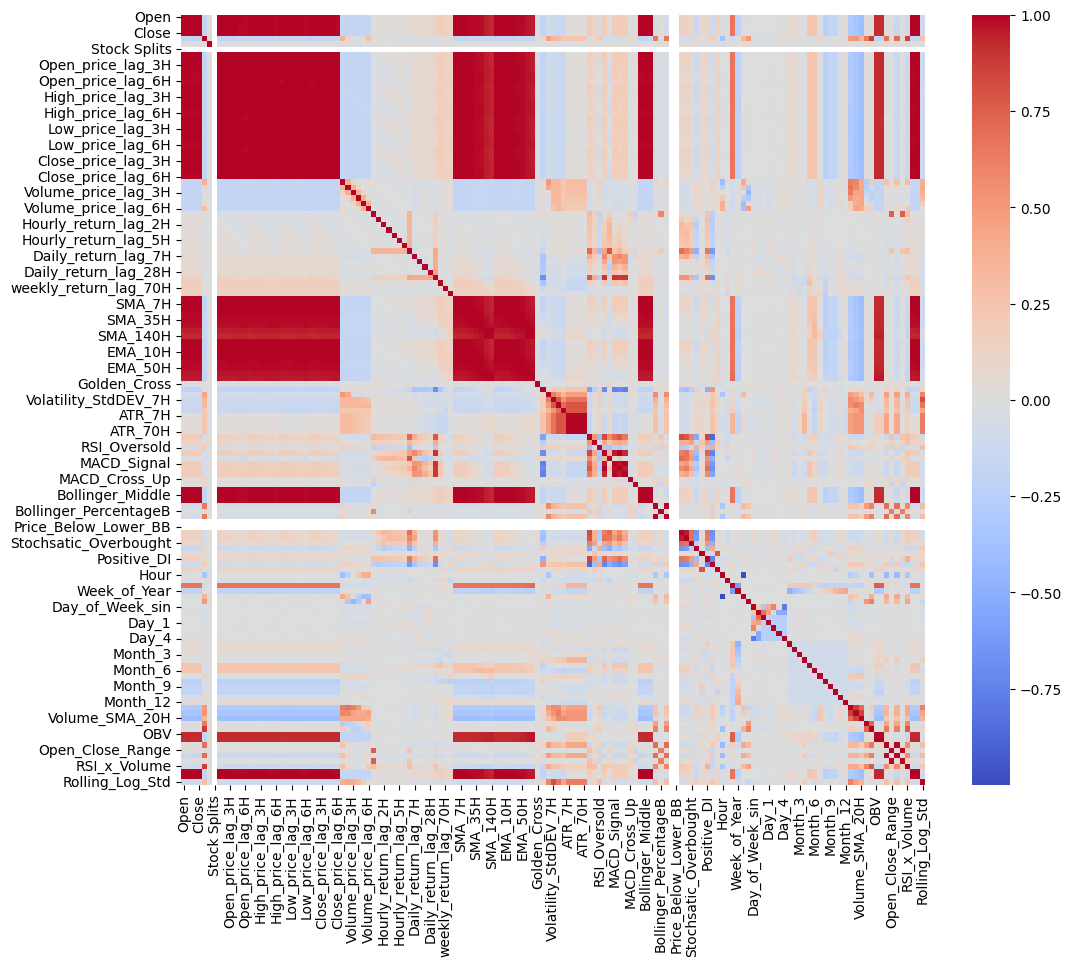

In [30]:
corr = msft_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()

In [31]:
corr['Close'].sort_values(ascending=False).head(15)

Close                 1.000000
Bollinger_Middle      0.999609
Low                   0.999525
High                  0.999522
Open                  0.999091
EMA_5H                0.998823
Bollinger_Upper       0.998628
Bollinger_Lower       0.998560
Log_Close             0.998529
Close_price_lag_1H    0.998435
SMA_5H                0.998187
EMA_7H                0.998154
High_price_lag_1H     0.997990
Low_price_lag_1H      0.997971
Open_price_lag_1H     0.997534
Name: Close, dtype: float64

#### Recursive Feature Elimination

In [32]:
msft_df = msft_df.dropna(how = 'any')
msft_df.columns[np.isinf(msft_df).any()]
msft_df.replace([np.inf, -np.inf], np.nan, inplace=True)
msft_df = msft_df.dropna(how='any')

In [33]:
X = msft_df.drop('Close', axis=1)
y = msft_df['Close']
xgb = XGBRegressor()
rfecv = RFECV(estimator=xgb, cv=5)
rfecv.fit(X, y)
optimal_num  = rfecv.n_features_
print(optimal_num)

4


In [34]:
rfe = RFE(estimator=xgb, n_features_to_select=optimal_num, step=1)
rfe = rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
X_rfe = X[selected_features]

#### Feature Impotance Tree Models

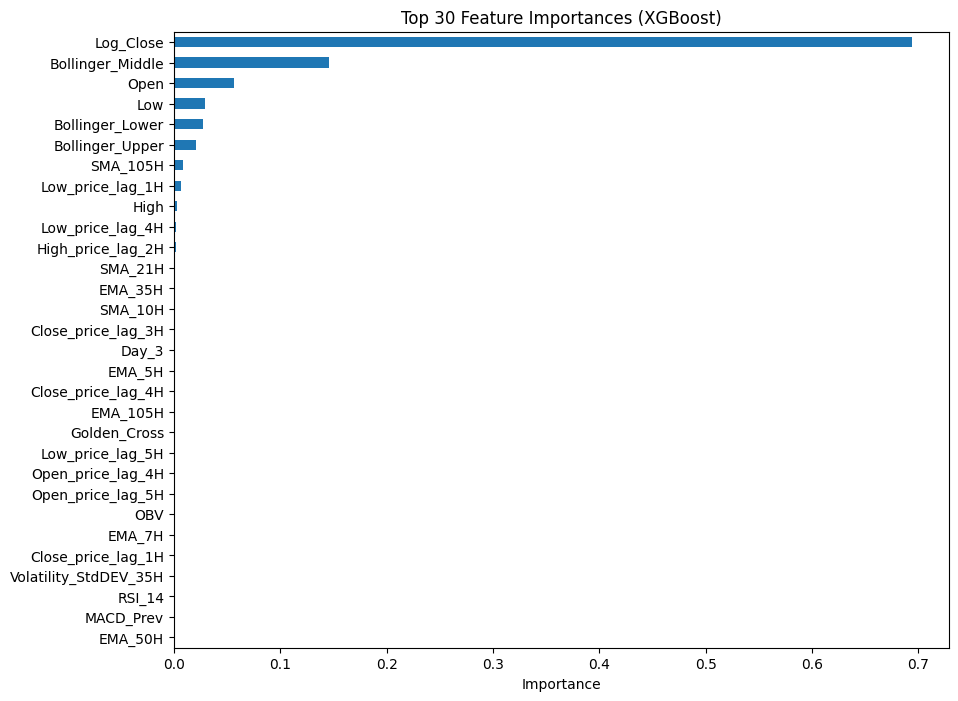

In [35]:
model = XGBRegressor()
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(30)

top_features.plot(kind='barh', figsize=(10,8))
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
tscv = TimeSeriesSplit(n_splits=100)

actual_values = []
predicted_values = []
simple_values = []

xgb = XGBRegressor()


for i, (train_idx, test_idx) in enumerate(tscv.split(msft_df)):
    print("fold:", i)
    print("Train dates:", msft_df.index[train_idx][[0, -1]])
    print("Test dates:", msft_df.index[test_idx][[0, -1]])

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb_fit = xgb.fit(X_train, y_train)
    y_pred = xgb_fit.predict(X_test.iloc[[0]])[0]

    actual_values.append(y_test.iloc[0])
    predicted_values.append(y_pred)
    simple_values.append(y_train.iloc[-1])

#### Results: No Transformations + All Features

In [ ]:
results_df = pd.DataFrame({
    "Actual_vs_Predicted": [mean_squared_error(actual_values, predicted_values)],
    "Actual_Vs_Simple": [mean_squared_error(actual_values, simple_values)]
})
print(results_df)

   Actual_vs_Predicted  Actual_Vs_Simple
0             0.002825           3.84902


## Hyperparameter Tuning

In [38]:
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3 ,5, 7],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0]
# }

# grid = GridSearchCV(xgb, param_grid, cv=TimeSeriesSplit(n_splits=5), verbose=1)
# grid.fit(X, y)
# print("Best params:", grid.best_params_)

In [ ]:
tscv = TimeSeriesSplit(n_splits=100)

xgb = XGBRegressor(
    n_estimators =  200,
    learning_rate = 0.1,
    max_depth = 7,
    subsample = 0.8
)

actual_values = []
predicted_values = []
simple_values = []


for i, (train_idx, test_idx) in enumerate(tscv.split(msft_df)):
    print("fold:", i)
    print("Train dates:", msft_df.index[train_idx][[0, -1]])
    print("Test dates:", msft_df.index[test_idx][[0, -1]])

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb_fit = xgb.fit(X_train, y_train)
    y_pred = model.predict(X_test.iloc[[0]])[0]

    actual_values.append(y_test.iloc[0])
    predicted_values.append(y_pred)
    simple_values.append(y_train.iloc[-1])

#### Results: No Transformations + All Features + Hyperparameters Tuned

In [40]:
results_df = pd.DataFrame({
    "Actual_vs_Predicted": [mean_squared_error(actual_values, predicted_values)],
    "Actual_Vs_Simple": [mean_squared_error(actual_values, simple_values)]
})
results_df

,Actual_vs_Predicted,Actual_Vs_Simple
0,0.002825,3.84902


In [ ]:
X = msft_df[selected_features]
y = msft_df['Close']

tscv = TimeSeriesSplit(n_splits=100)

xgb = XGBRegressor(
)

actual_values = []
predicted_values = []
simple_values = []

for i, (train_idx, test_idx) in enumerate(tscv.split(msft_df)):
    print("fold:", i)
    print("Train dates:", msft_df.index[train_idx][[0, -1]])
    print("Test dates:", msft_df.index[test_idx][[0, -1]])

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb_fit = xgb.fit(X_train, y_train)
    y_pred = xgb_fit.predict(X_test.iloc[[0]])[0]

    actual_values.append(y_test.iloc[0])
    predicted_values.append(y_pred)
    simple_values.append(y_train.iloc[-1])

### Results: No Transformations + Optimal Features

In [110]:
results_df = pd.DataFrame({
    "Actual_vs_Predicted": [mean_squared_error(actual_values, predicted_values)],
    "Actual_Vs_Simple": [mean_squared_error(actual_values, simple_values)]
})
results_df

,Actual_vs_Predicted,Actual_Vs_Simple
0,0.308602,3.84902


In [ ]:
msft_df = msft_df.dropna(subset=['Rolling_Log_Avg'])

X = msft_df.drop(['Rolling_Log_Avg', 'Close'], axis=1)
y = msft_df['Rolling_Log_Avg']

tscv = TimeSeriesSplit(n_splits=100)

xgb = XGBRegressor()

actual_values = []
predicted_values = []
simple_values = []


for i, (train_idx, test_idx) in enumerate(tscv.split(msft_df)):
    print("fold:", i)
    print("Train dates:", msft_df.index[train_idx][[0, -1]])
    print("Test dates:", msft_df.index[test_idx][[0, -1]])

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb_fit = xgb.fit(X_train, y_train)
    y_pred = xgb_fit.predict(X_test.iloc[[0]])[0]

    actual_values.append(y_test.iloc[0])
    predicted_values.append(y_pred)
    simple_values.append(y_train.iloc[-1])

### Results: Transformations + All Features

In [91]:
results_df = pd.DataFrame({
    "Actual_vs_Predicted": [mean_squared_error(actual_values, predicted_values)],
    "Actual_Vs_Simple": [mean_squared_error(actual_values, simple_values)]
})
results_df

,Actual_vs_Predicted,Actual_Vs_Simple
0,0.000004,0.000004


In [ ]:
X = msft_df.drop(['Rolling_Log_Avg', 'Close'], axis=1)
y = msft_df['Close']

tscv = TimeSeriesSplit(n_splits=100)

xgb = XGBRegressor()

actual_values = []
predicted_values = []
simple_values = []


for i, (train_idx, test_idx) in enumerate(tscv.split(msft_df)):
    print("fold:", i)
    print("Train dates:", msft_df.index[train_idx][[0, -1]])
    print("Test dates:", msft_df.index[test_idx][[0, -1]])

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb_fit = xgb.fit(X_train, y_train)
    y_pred = xgb_fit.predict(X_test.iloc[[0]])[0]

    actual_values.append(y_test.iloc[0])
    predicted_values.append(y_pred)
    simple_values.append(y_train.iloc[-1])

### Results: Transformations + Optimal Features 

In [114]:
results_df = pd.DataFrame({
    "Actual_vs_Predicted": [mean_squared_error(actual_values, predicted_values)],
    "Actual_Vs_Simple": [mean_squared_error(actual_values, simple_values)]
})
results_df

,Actual_vs_Predicted,Actual_Vs_Simple
0,0.514668,3.84902
